# Causal Inference in Decision Intelligence – Part 12: Relaxing DiD assumptions

Link to the article:  [Relaxing DiD assumptions](https://www.linkedin.com/pulse/causal-inference-decision-intelligence-part-12-did-eugene-zinoviev-x0dkc)

## Import libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import networkx as nx
import statsmodels.formula.api as smf
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
pd.options.display.float_format='{:,.2f}'.format

In [2]:
# Set the sample size
n = 1000

## Difference in differences with parallel trends and carryover effect

### Generate data

In [3]:
# Generate customers' Ids 
Promo = pd.Series(range(1,1001))

# Generate dates 
start_date = '2024-05-02'
end_date = '2024-05-07'
Dates = pd.date_range(start=start_date, end=end_date)

# Create the product of Ids and dates
data_did = pd.DataFrame(product(Dates, Promo))
data_did = data_did.rename(columns={0: 'Date', 1: "Id"})

# Create promo groups 
data_did['Promo'] = np.where(data_did.Id<501, 1, 0)

# Create the event

data_did['Event'] = np.where(data_did.Date=='2024-05-04', 1, 0)

In [4]:
# Generate Sales
np.random.seed(4)
data_did['Sales'] = np.where(data_did.Id<501, 20, 10)
data_did['Sales'] = np.where(((data_did.Date=='2024-05-04') & (data_did.Id>500)), 15, data_did.Sales)
data_did['Sales'] = np.where(((data_did.Date=='2024-05-04') & (data_did.Id<501)), 35, data_did.Sales)
data_did['Sales'] = np.where(((data_did.Date=='2024-05-05') & (data_did.Id>500)), 13, data_did.Sales)
data_did['Sales'] = np.where(((data_did.Date=='2024-05-05') & (data_did.Id<501)), 29, data_did.Sales)
data_did['Sales'] = np.where(((data_did.Date=='2024-05-06') & (data_did.Id>500)), 11, data_did.Sales)
data_did['Sales'] = np.where(((data_did.Date=='2024-05-06') & (data_did.Id<501)), 23, data_did.Sales)
data_did['Sales'] = data_did['Sales'] + np.random.randn(6000)

# Generate post-treatment dates
data_did['Date1'] = np.where(data_did.Date=='2024-05-05', 1, 0)
data_did['Date2'] = np.where(data_did.Date=='2024-05-06', 1, 0)
data_did['Date3'] = np.where(data_did.Date=='2024-05-07', 1, 0)

### Estimate the effect

In [5]:
# DiD with parallel trends without a carryover effect
df = data_did[data_did.Date<'2024-05-05']

model_did1 = smf.ols('Sales ~ Promo*Event', df).fit()
model_did1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.0145,0.031,325.975,0.000,9.954,10.075
Promo,10.0244,0.043,230.728,0.000,9.939,10.110
Event,4.9510,0.053,93.043,0.000,4.847,5.055
Promo:Event,10.0125,0.075,133.053,0.000,9.865,10.160


In [6]:
# DiD with carryover effect
model_didco = smf.ols('Sales ~ Promo*Event + Promo*Date1 + Promo*Date2 + Promo*Date3', data_did).fit()
model_didco.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.0145,0.031,321.305,0.000,9.953,10.076
Promo,10.0244,0.044,227.423,0.000,9.938,10.111
Event,4.9510,0.054,91.711,0.000,4.845,5.057
Promo:Event,10.0125,0.076,131.147,0.000,9.863,10.162
Date1,2.9404,0.054,54.468,0.000,2.835,3.046
Promo:Date1,6.0426,0.076,79.148,0.000,5.893,6.192
Date2,0.9964,0.054,18.457,0.000,0.891,1.102
Promo:Date2,1.9637,0.076,25.721,0.000,1.814,2.113
Date3,-0.0248,0.054,-0.460,0.646,-0.131,0.081
Promo:Date3,0.0104,0.076,0.136,0.892,-0.139,0.160


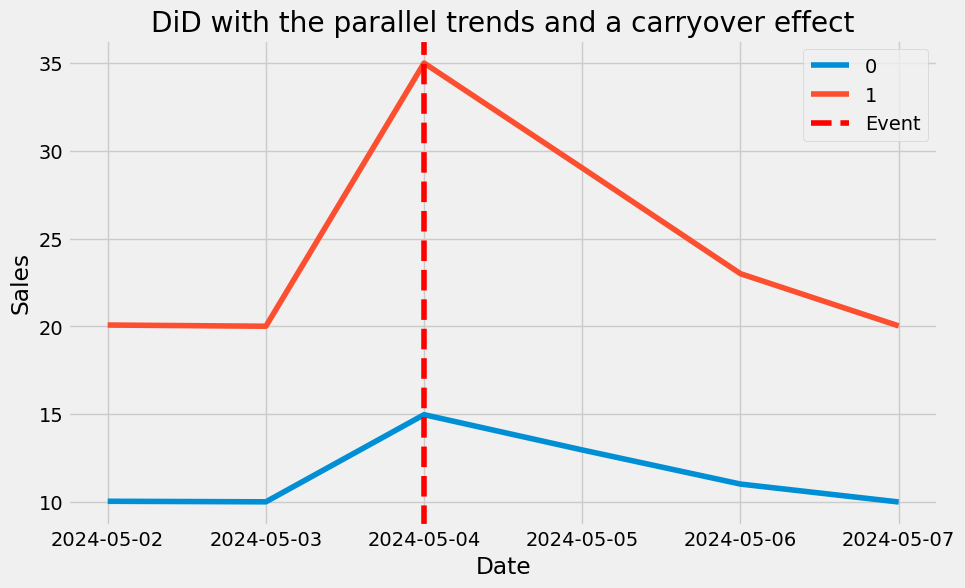

In [7]:
# Draw the carryover effect
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Sales', hue='Promo', data=data_did)

# Add a vertical line at the event date
event_date = pd.to_datetime('2024-05-04')
plt.axvline(x=event_date, color='red', linestyle='--', label='Event')

# Set the title and labels
plt.title('DiD with the parallel trends and a carryover effect')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.legend()

plt.savefig('didco.png')

# Show the plot
plt.show();

### Explanation of the analysis

In [8]:
# Extract the coefficients
coef_didco = dict(model_didco.params)
coef_didco = pd.DataFrame([coef_didco]).T
coef_didco = coef_didco.rename(columns={0: "Coeff"})
coef_didco.reset_index(inplace=True)


In [9]:
# Create a dataset with the estimated effects 
Didco = pd.DataFrame(Dates)
Didco = Didco.rename(columns={0: "Date"})
Didco['Control'] = coef_didco.iloc[0,1]
Didco['Event'] = np.where((Didco.Date=='2024-05-04') , Didco['Control'] + coef_didco.iloc[2,1], Didco.Control)
Didco['Event'] = np.where((Didco.Date=='2024-05-05') , Didco['Control'] + coef_didco.iloc[4,1], Didco.Event)
Didco['Event'] = np.where((Didco.Date=='2024-05-06') , Didco['Control'] + coef_didco.iloc[6,1], Didco.Event)
Didco['Event'] = np.where((Didco.Date=='2024-05-07') , Didco['Control'] + coef_didco.iloc[8,1], Didco.Event)

Didco['Parallel'] = Didco['Event'] + coef_didco.iloc[1,1]

Didco['Test'] = np.where((Didco.Date=='2024-05-04') , Didco['Parallel'] + coef_didco.iloc[3,1], Didco.Parallel)
Didco['Test'] = np.where((Didco.Date=='2024-05-05') , Didco['Parallel'] + coef_didco.iloc[5,1], Didco.Test)
Didco['Test'] = np.where((Didco.Date=='2024-05-06') , Didco['Parallel'] + coef_didco.iloc[7,1], Didco.Test)
Didco['Test'] = np.where((Didco.Date=='2024-05-07') , Didco['Parallel'] + coef_didco.iloc[9,1], Didco.Test)

Didco['Effect'] = Didco.Test - Didco.Parallel
Didco

,Date,Control,Event,Parallel,Test,Effect
0,2024-05-02,10.01,10.01,20.04,20.04,0.00
1,2024-05-03,10.01,10.01,20.04,20.04,0.00
2,2024-05-04,10.01,14.97,24.99,35.00,10.01
3,2024-05-05,10.01,12.95,22.98,29.02,6.04
4,2024-05-06,10.01,11.01,21.04,23.00,1.96
5,2024-05-07,10.01,9.99,20.01,20.02,0.01


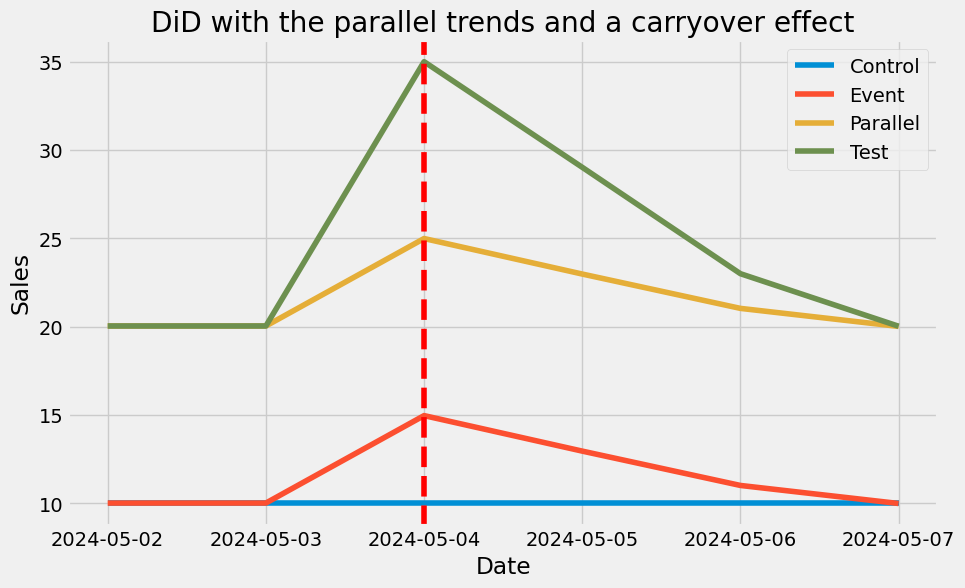

In [10]:
# Draw a diagram explaining DiD with carryover effect
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Control', data=Didco, label='Control')
sns.lineplot(x='Date', y='Event', data=Didco, label='Event')
sns.lineplot(x='Date', y='Parallel', data=Didco, label='Parallel')
sns.lineplot(x='Date', y='Test', data=Didco, label='Test')

# Add a vertical line at the event date
event_date = pd.to_datetime('2024-05-04')
plt.axvline(x=event_date, color='red', linestyle='--')


# Set the title and labels
plt.title('DiD with the parallel trends and a carryover effect')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

plt.savefig('didco2.png')
# Show the plot
plt.show();

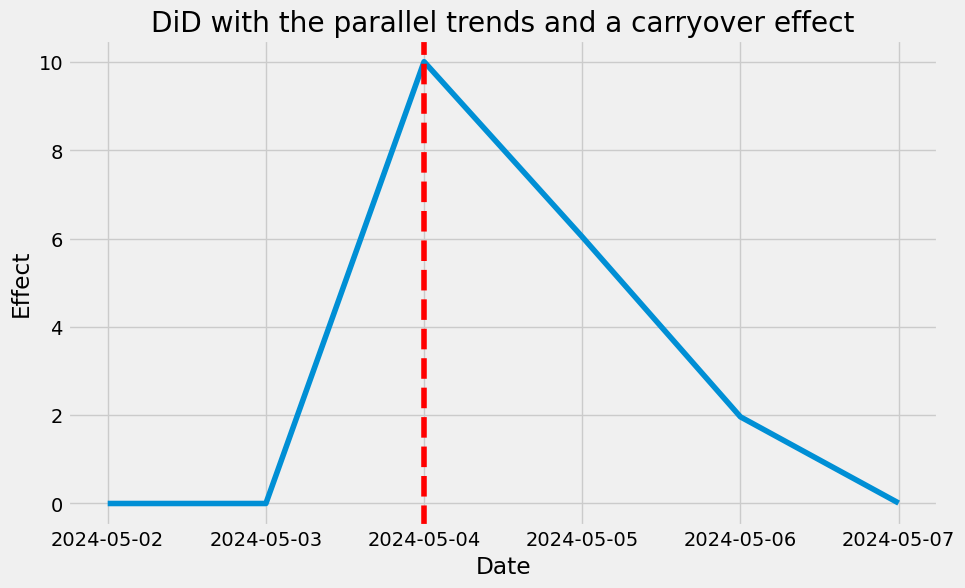

In [11]:
# Draw the diagram demonstrating the carryover effect
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Effect', data=Didco)

# Add a vertical line at the event date
event_date = pd.to_datetime('2024-05-04')
plt.axvline(x=event_date, color='red', linestyle='--')


# Set the title and labels
plt.title('DiD with the parallel trends and a carryover effect')
plt.xlabel('Date')
plt.ylabel('Effect')
plt.savefig('didco3.png')

# Show the plot
plt.show();

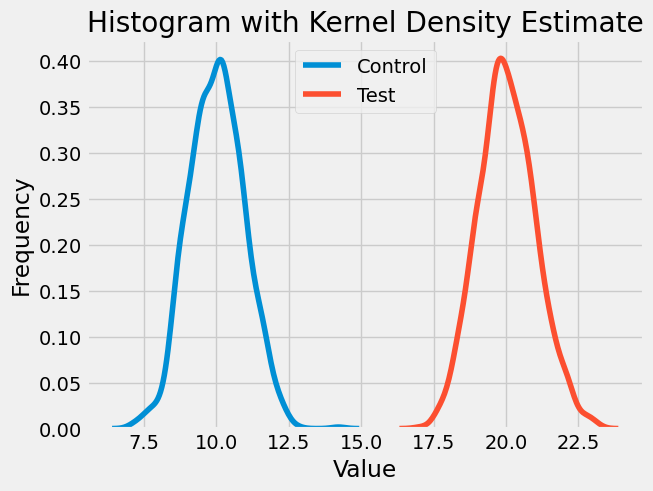

In [12]:
# Plot KDE diagram of the sales distribution 
df2 = data_did[data_did.Date<'2024-05-04']
sns.kdeplot(df2[df2.Promo==0].Sales, label="Control")
sns.kdeplot(df2[df2.Promo==1].Sales, label="Test")


# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Kernel Density Estimate')
plt.legend()
plt.savefig('didco4.png')
plt.show();



## Difference in differences with selection bias

### Generate data

In [13]:
np.random.seed(2)
# Generate customers' Ids 
Promo = pd.Series(range(1,1001))

# Generate dates 
start_date = '2024-05-02'
end_date = '2024-05-07'
Dates = pd.date_range(start=start_date, end=end_date)

# Create the product of Ids and dates
data_did1 = pd.DataFrame(product(Dates, Promo))
data_did1 = data_did1.rename(columns={0: 'Date', 1: "Id"})

# Create promo groups 
data_did1['Promo'] = np.where(data_did1.Id<501, 1, 0)

# Create the event
data_did1['Event'] = np.where(data_did1.Date=='2024-05-04', 1, 0)

In [14]:
# Generate Sales
np.random.seed(4)
data_did1['Sales'] = np.where(data_did1.Id<501, 20, 10)

data_did1['Sales'] = np.where(((data_did1.Date=='2024-05-04') & (data_did1.Id>500)), 15, data_did1.Sales)
data_did1['Sales'] = np.where(((data_did1.Date=='2024-05-04') & (data_did1.Id<501)), 35, data_did1.Sales)
data_did1['Sales'] = np.where(((data_did1.Date=='2024-05-05') & (data_did1.Id>500)), 13, data_did1.Sales)
data_did1['Sales'] = np.where(((data_did1.Date=='2024-05-05') & (data_did1.Id<501)), 29, data_did1.Sales)
data_did1['Sales'] = np.where(((data_did1.Date=='2024-05-06') & (data_did1.Id>500)), 11, data_did1.Sales)
data_did1['Sales'] = np.where(((data_did1.Date=='2024-05-06') & (data_did1.Id<501)), 23, data_did1.Sales)
data_did1['Sales'] = data_did1['Sales'] + np.random.normal(0, 5, 6000)
data_did1.sample(20)
data_did1['Date1'] = np.where(data_did1.Date=='2024-05-05', 1, 0)
data_did1['Date2'] = np.where(data_did1.Date=='2024-05-06', 1, 0)
data_did1['Date3'] = np.where(data_did1.Date=='2024-05-07', 1, 0)

df = data_did1[data_did1.Date<'2024-05-03']
df['High'] = np.where(df.Sales>15, 1, 0)
df2 = df[['Id', 'High']]
data_did2 = pd.merge(data_did1, df2, on=['Id'],how='left')
data_did2['Sales'] = np.where(((data_did2.High==1) & (data_did2.Event==1)), data_did2.Sales+4, data_did2.Sales)

In [15]:
# Distribution of Hi and low income customers
round(pd.pivot_table(data_did2, values='Sales', index='Promo', columns='High', aggfunc='count'), 1)

High,0,1
Promo,,
0,2550,450
1,408,2592


### Estimate the effect

In [16]:
# DiD with parallel trends
df3 = data_did2[data_did2.Date<'2024-05-05']
#df1 = data_did[data_did.Date=='2024-05-04']

model_did1 = smf.ols('Sales ~ Promo*Event', data_did2).fit()
model_did1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.7843,0.110,98.272,0.000,10.569,10.999
Promo,11.7387,0.155,75.638,0.000,11.434,12.043
Event,4.6428,0.269,17.272,0.000,4.116,5.170
Promo:Event,11.3020,0.380,29.730,0.000,10.557,12.047


In [17]:
# Extract the coefficients
coef_did1 = dict(model_did1.params)
coef_did1 = pd.DataFrame([coef_did1]).T
coef_did1 = coef_did1.rename(columns={0: "Coeff"})
coef_did1.reset_index(inplace=True)
coef_did1

,index,Coeff
0,Intercept,10.78
1,Promo,11.74
2,Event,4.64
3,Promo:Event,11.30


In [18]:
# Calculate the effects 
print(f'The effect of Event is: {round(coef_did1.iloc[2,1], 2)}')
print(f'The effect of Promo is: {round(coef_did1.iloc[3,1], 2)}')
print(f'The total effect  is: {round((coef_did1.iloc[2,1] + coef_did1.iloc[3,1]), 2)}')

The effect of Event is: 4.64
The effect of Promo is: 11.3
The total effect  is: 15.94


In [19]:
data_did2.groupby(['Promo', 'Event', 'High']).Sales.mean()

Promo  Event  High
0      0      0      10.58
              1      11.92
       1      0      14.84
              1      18.74
1      0      0      21.54
              1      22.68
       1      0      34.72
              1      39.06
Name: Sales, dtype: float64

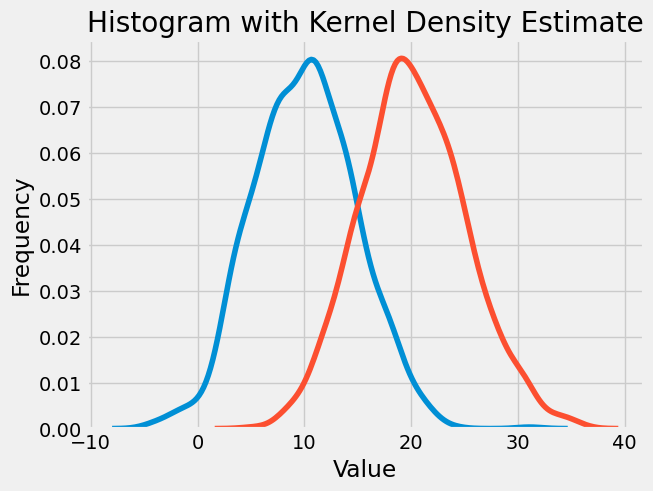

In [20]:
df3 = data_did2[data_did2.Date<'2024-05-04']

sns.kdeplot(df3[df3.Promo==0].Sales, label="Control")
sns.kdeplot(df3[df3.Promo==1].Sales, label="Test")


# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Kernel Density Estimate')
plt.savefig('didsb1.png')
plt.show();

In [21]:
# Estimate the effect with conditionally parallel trends (selection bias)
model_did2 = smf.ols('Sales ~ Promo*Event*High', data_did2).fit()
model_did2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.5844,0.118,89.646,0.000,10.353,10.816
Promo,10.9575,0.318,34.467,0.000,10.334,11.581
Event,4.2583,0.289,14.724,0.000,3.691,4.825
Promo:Event,8.9158,0.779,11.449,0.000,7.389,10.442
High,1.3331,0.305,4.373,0.000,0.736,1.931
Promo:High,-0.1975,0.440,-0.449,0.654,-1.060,0.665
Event:High,2.5634,0.747,3.433,0.001,1.100,4.027
Promo:Event:High,0.6435,1.078,0.597,0.551,-1.470,2.757


In [22]:
# Extract the coefficients
coef_did2 = dict(model_did2.params)
coef_did2 = pd.DataFrame([coef_did2]).T
coef_did2 = coef_did2.rename(columns={0: "Coeff"})
coef_did2.reset_index(inplace=True)
coef_did2

,index,Coeff
0,Intercept,10.58
1,Promo,10.96
2,Event,4.26
3,Promo:Event,8.92
4,High,1.33
5,Promo:High,-0.20
6,Event:High,2.56
7,Promo:Event:High,0.64


In [23]:
Did2 = pd.DataFrame({'Date': ['2024-05-02', '2024-05-03', '2024-05-04']})
Did2['Control'] = coef_did2.iloc[0,1] * 0.85 + (coef_did2.iloc[0,1] + coef_did2.iloc[4,1]) * 0.15
Did2['Test'] = Did2['Control'] + coef_did2.iloc[1,1] * 0.136 + (coef_did2.iloc[1,1] + coef_did2.iloc[5,1]) * 0.864
Did2['Event_control'] = np.where((Did2.Date=='2024-05-04') , Did2['Control'] + coef_did2.iloc[2,1] * 0.85 + (coef_did2.iloc[2,1] + coef_did2.iloc[6,1]) * 0.15 , Did2.Control)
Did2['Event_test'] = np.where((Did2.Date=='2024-05-04') , Did2['Test'] + coef_did2.iloc[2,1] * 0.136 + (coef_did2.iloc[2,1] + coef_did2.iloc[6,1]) * 0.864 , Did2['Test'])
Did2['Promo'] = np.where((Did2.Date=='2024-05-04') , Did2['Event_test'] + coef_did2.iloc[3,1] * 0.136 + (coef_did2.iloc[3,1] + coef_did2.iloc[7,1]) * 0.864 , Did2['Test'])
Did2

,Date,Control,Test,Event_control,Event_test,Promo
0,2024-05-02,10.78,21.57,10.78,21.57,21.57
1,2024-05-03,10.78,21.57,10.78,21.57,21.57
2,2024-05-04,10.78,21.57,15.43,28.04,37.52


In [24]:
# Calculate the effects 
print(f'The effect of Event for the control group is: {round((Did2.iloc[2,3] - Did2.iloc[1,3]), 2)}')
print(f'The effect of Event for the test group is: {round((Did2.iloc[2,4] - Did2.iloc[1,4]), 2)}')
print(f'The total effect is: {round((Did2.iloc[2,5] - Did2.iloc[1,5]), 2)}')
print(f'The effect of Promo is: {round(((Did2.iloc[2,5] - Did2.iloc[1,5]) - (Did2.iloc[2,4] - Did2.iloc[1,4])), 2)}')

The effect of Event for the control group is: 4.64
The effect of Event for the test group is: 6.47
The total effect is: 15.94
The effect of Promo is: 9.47


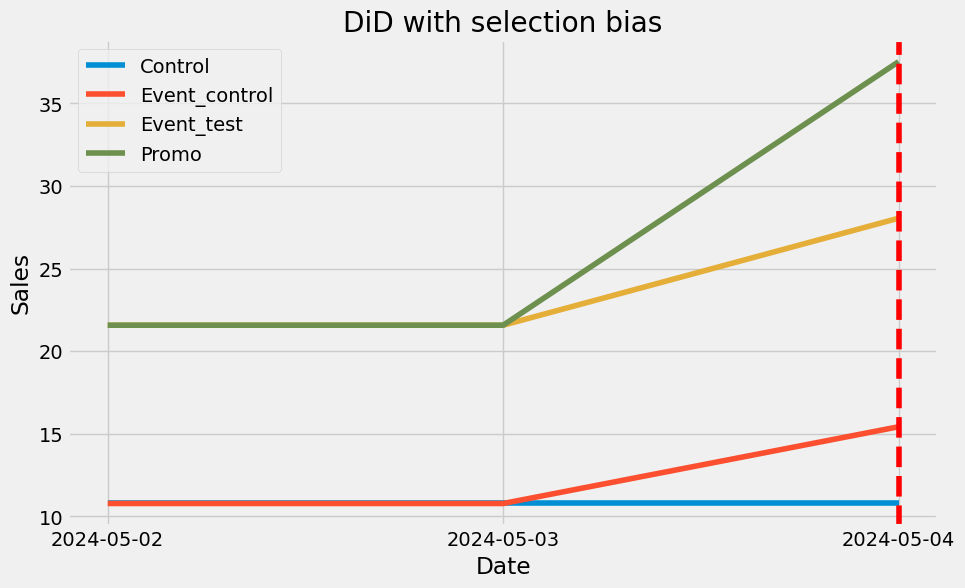

In [25]:
# Draw the effects
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Control', data=Did2, label='Control')
sns.lineplot(x='Date', y='Event_control', data=Did2, label='Event_control')
sns.lineplot(x='Date', y='Event_test', data=Did2, label='Event_test')
sns.lineplot(x='Date', y='Promo', data=Did2, label='Promo')

# Add a vertical line at the event date
plt.axvline(x='2024-05-04', color='red', linestyle='--')


# Set the title and labels
plt.title('DiD with selection bias')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.savefig('didsb2.png')
# Show the plot
plt.show();

## Synthetic control (non-parallel trends)

### Generate data

In [26]:
# Generate dates 
start_date = '2024-05-02'
end_date = '2024-05-14'
Dates = pd.date_range(start=start_date, end=end_date)

# Create the product of Ids and dates
data_syn = pd.DataFrame({'Date': Dates})

np.random.seed(5)
data_syn['Region1'] = np.random.normal(loc=5, scale=5, size=13)
data_syn['Region2'] = np.random.normal(loc=7, scale=4, size=13)
data_syn['Region_test'] = 0.8 * data_syn['Region1'] + 1.1 * data_syn['Region2'] + np.random.normal(loc=0, scale=1, size=13)
data_syn['Region_test'] = np.where((data_syn['Date']>='2024-05-10'), data_syn['Region_test']+3, data_syn['Region_test'])
data_syn

,Date,Region1,Region2,Region_test
0,2024-05-02,7.21,9.41,16.18
1,2024-05-03,3.35,0.34,2.69
2,2024-05-04,17.15,4.20,18.35
3,2024-05-05,3.74,11.61,15.65
4,2024-05-06,5.55,14.43,21.10
5,2024-05-07,12.91,0.96,10.75
6,2024-05-08,0.45,9.58,10.89
7,2024-05-09,2.04,3.08,4.92
8,2024-05-10,5.94,3.57,11.63
9,2024-05-11,3.35,3.51,9.79


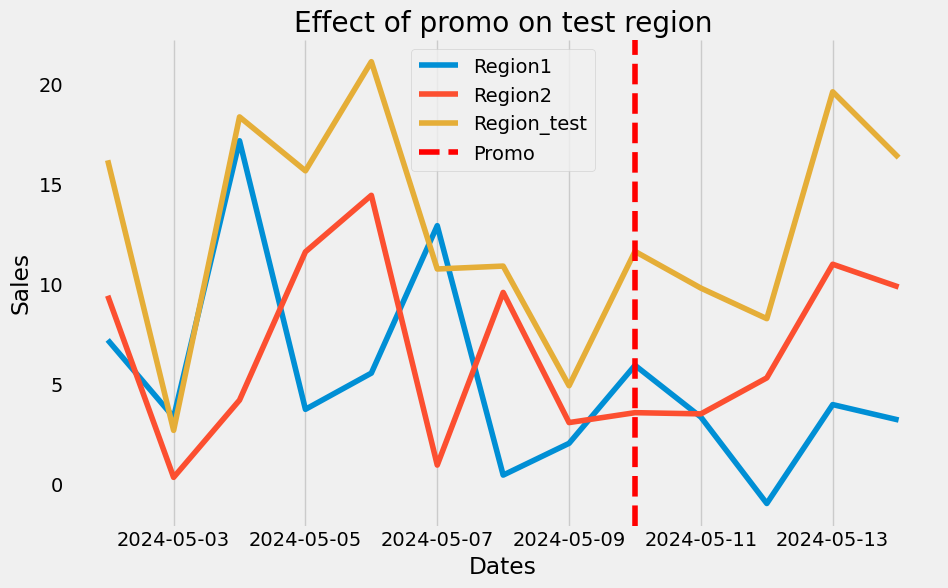

In [27]:
# Plot Sales series for three regions
plt.figure(figsize=(10, 6))
plt.plot(data_syn['Date'], data_syn['Region1'], label='Region1') 
plt.plot(data_syn['Date'], data_syn['Region2'], label='Region2') 
plt.plot(data_syn['Date'], data_syn['Region_test'], label='Region_test') 

plt.axvline(x=data_syn['Date'][8], color='red', linestyle='--', label='Promo')

# Add titles and labels 
plt.title('Effect of promo on test region') 
plt.xlabel('Dates') 
plt.ylabel('Sales') 

plt.grid(axis="y")

# Remove the border (spines) of the graph 
plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['left'].set_visible(False) 
plt.gca().spines['bottom'].set_visible(False)
# Add a legend 
plt.legend() 
plt.savefig('syn.png')
# Show the plot 
plt.show();

In [28]:
# Create the synthetic series
data_c = data_syn[data_syn.Date<'2024-05-10']
model_c = smf.ols('Region_test ~ Region1 + Region2', data_c).fit()
model_c.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.5145,0.243,-2.115,0.088,-1.140,0.111
Region1,0.8058,0.020,40.811,0.000,0.755,0.857
Region2,1.1646,0.022,53.930,0.000,1.109,1.220


In [29]:
# Add the synthetic series and the promo effect to the data frame
data_syn['Region_syn'] = model_c.params[0] + model_c.params[1] * data_syn.Region1 + model_c.params[2]* data_syn.Region2
data_syn['Promo_effect'] = data_syn.Region_test - data_syn.Region_syn

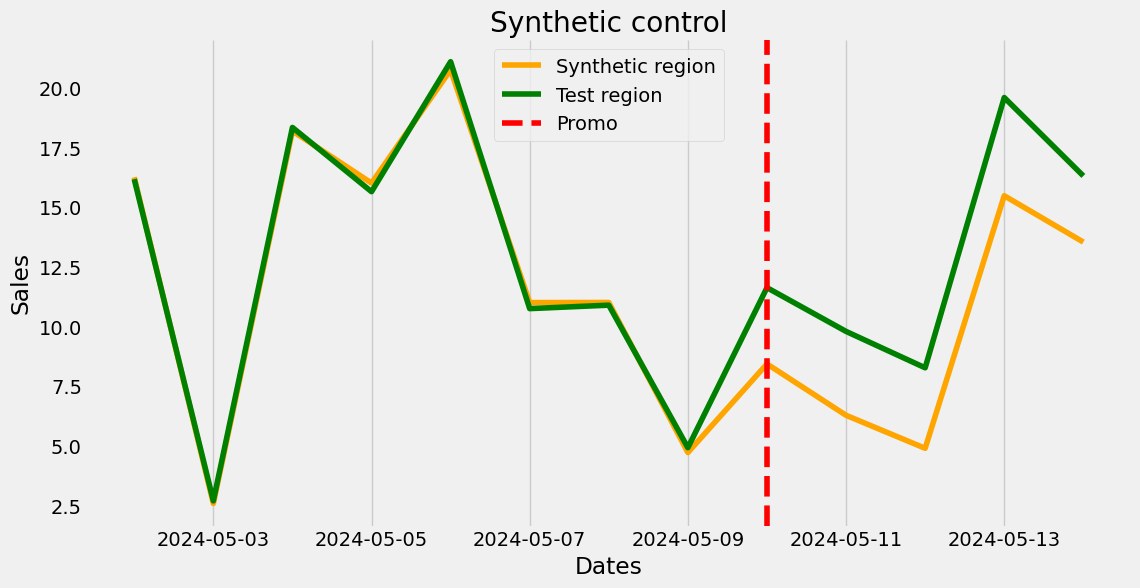

In [32]:
# Plot the result
plt.figure(figsize=(12, 6))
plt.plot(data_syn['Date'], data_syn['Region_syn'], color='orange', label='Synthetic region')  
plt.plot(data_syn['Date'], data_syn['Region_test'], color='green', label='Test region') 

plt.axvline(x=data_syn['Date'][8], color='red', linestyle='--', label='Promo')

# Add titles and labels 
plt.title('Synthetic control') 
plt.xlabel('Dates') 
plt.ylabel('Sales') 

plt.grid(axis="y")

# Remove the border (spines) of the graph 
plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['left'].set_visible(False) 
plt.gca().spines['bottom'].set_visible(False)

# Add a legend 
plt.legend() 
plt.savefig('syn2.png')
# Show the plot 
plt.show();

In [31]:
# Calculate the effect
effect = data_syn[['Date', 'Promo_effect']]
effect = effect[effect.Date>='2024-05-10']
print('Average event uplift:')
effect

Average event uplift:


,Date,Promo_effect
8,2024-05-10,3.20
9,2024-05-11,3.52
10,2024-05-12,3.37
11,2024-05-13,4.12
12,2024-05-14,2.77
